In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-14 23:24:13.806168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [5]:
load_bsccm_images(bsccm, 'Brightfield', 100, batch=0).mean()

Array(1737.65524556, dtype=float64)

Rescale fraction:  0.10504858040956251


9it [00:00, 131.13it/s]
9it [00:00, 320.67it/s]


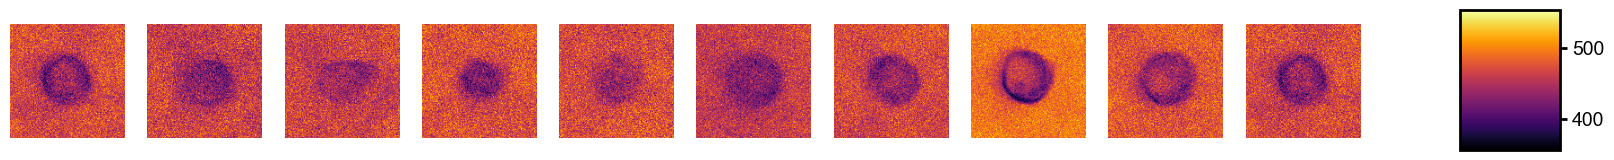

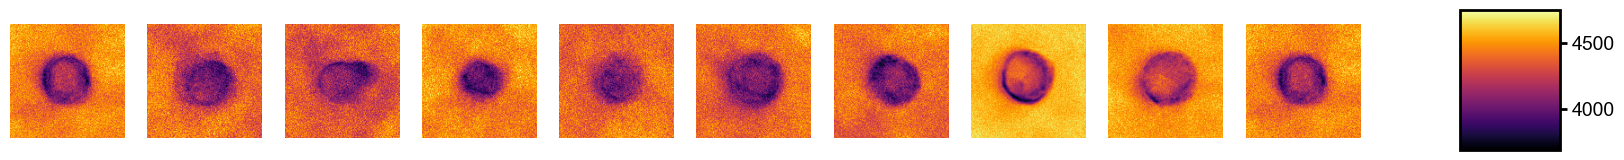

In [11]:
def load_and_plot(data):

    image_dim = bsccm.global_metadata['led_array']['image_shape'][0]
    markers, image_target_generator, dataset_size, display_range, _ = get_bsccm_image_marker_generator(bsccm, image_dim=image_dim, **data )

    images = []
    for image, target in tqdm(image_target_generator()):
        images.append(image)
        if len(images) == 10:
            break

    # plot them
    fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 2, 2))
    for i, image in enumerate(images):
        ax[i].imshow(image, cmap='inferno')
        ax[i].axis('off')

    # show colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(ax[0].imshow(image, cmap='inferno'), cax=cbar_ax)


config_path = '/home/hpinkard_waller/GitRepos/EncodingInformation/' + \
                'led_array/phenotyping_experiments/config_files/pending/Synthetic_Noise_v9_Brightfield_450photons_replicate_0.yaml'
# safe load yaml
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

load_and_plot(config['data'])


modified_config = config.copy()
del modified_config['data']['synthetic_noise']

load_and_plot(modified_config['data'])

In [7]:
print(np.mean(noisy_patches), np.mean(images))

48.535378 52.654495


In [6]:
vals = []
for _, target in tqdm(test_dataset):
    if not np.isnan(target[markers.index('CD3')] ):
        CD3_vals.append(target[markers.index('CD3')])

10058it [02:51, 58.64it/s]


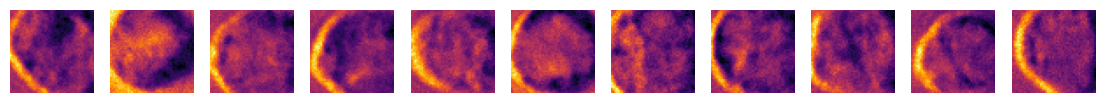

In [35]:
hack_config = config.copy()
hack_config['data']['batch'] = 0
hack_config['data']['synthetic_noise']['photons_per_pixel'] = 800

markers, image_target_generator, dataset_size, display_range, indices = get_bsccm_image_marker_generator(bsccm, **hack_config['data'])

images = []
for image, target in image_target_generator():
    images.append(image)
    if len(images) > 10:
        break


# plot images
fig, axs = plt.subplots(1, len(images), figsize=(14, 14))
for i, image in enumerate(images):
    axs[i].imshow(image[40:-40, 40:-40], cmap='inferno')
    axs[i].axis('off')

# # plot histogram of mean pixel values
# fig, axs = plt.subplots(1, 1, figsize=(6, 6))
# _ = axs.hist(np.mean(images, axis=(1, 2)), bins=50)

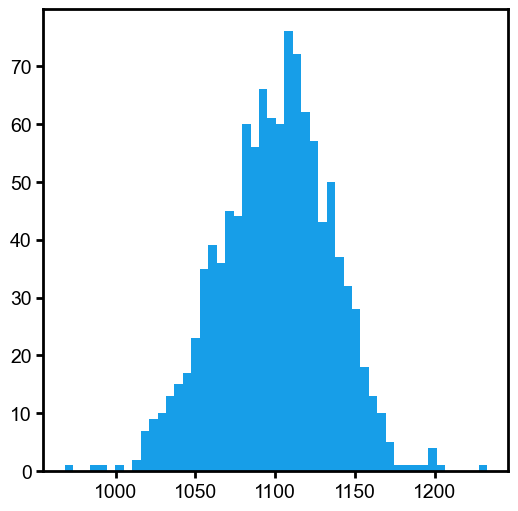

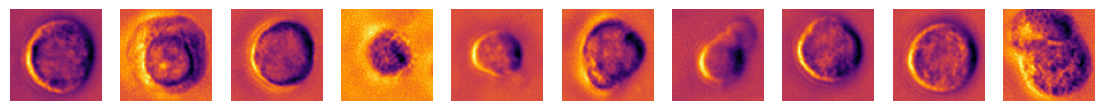

In [22]:
markers, targets, indices, display_range, dataset_size = get_targets_and_display_range(bsccm, 
                            True, 0, shuffle=True, shuffle_seed=123)

images = load_bsccm_images(bsccm, 'DPC_Right', indices=indices[::100], edge_crop=24)

# plot histogram of mean pixel values
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
_ = axs.hist(np.mean(images, axis=(1, 2)), bins=50)

# plot a few images
fig, axs = plt.subplots(1, 10, figsize=(14, 14))
for i, image in enumerate(images[:10]):
    axs[i].imshow(image, cmap='inferno')
    axs[i].axis('off')